   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

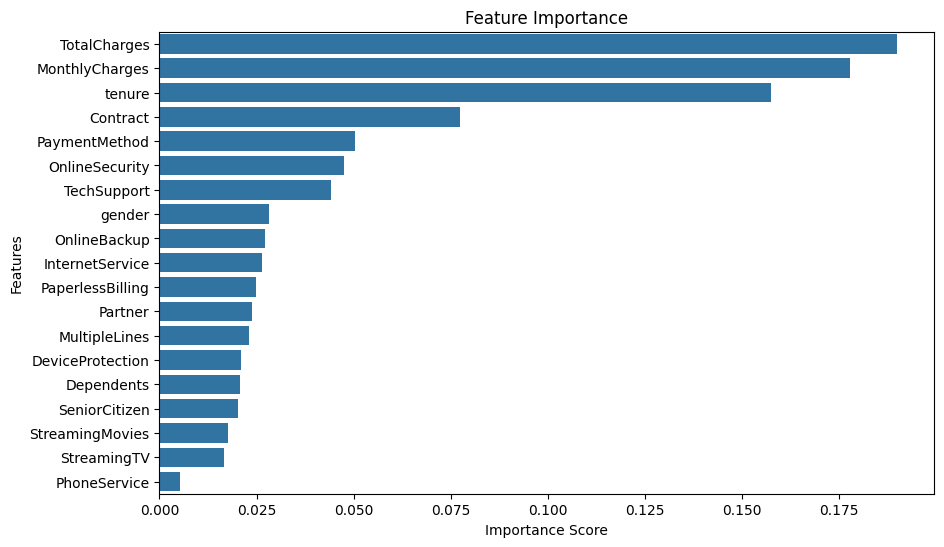

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Model Accuracy: 0.8097941802696949
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

✅ Model saved as churn_model.pkl

📋 Let's predict a new customer!


In [ ]:
# Customer Churn Prediction - Extended Version

# 1. Install libraries
!pip install -q scikit-learn pandas matplotlib seaborn joblib

# 2. Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 3. Load data
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"  # Corrected URL
df = pd.read_csv(url)

# 4. Data exploration
print(df.head())
print(df.info())
print(df['Churn'].value_counts())

# 5. Preprocess data
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 6. Train/test split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train a basic model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 8. Evaluate basic model
y_pred = model.predict(X_test)
print("Initial Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 9. Feature Importance Plot
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance")
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 10. Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# 11. Evaluate tuned model
y_pred_best = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# 12. Save the model
joblib.dump(best_model, 'churn_model.pkl')
print("✅ Model saved as churn_model.pkl")

# 13. Simple User Prediction
def predict_user_input(model):
    print("\n📋 Let's predict a new customer!")
    tenure = float(input("Tenure (months): "))
    monthly_charges = float(input("Monthly Charges: "))
    total_charges = float(input("Total Charges: "))
    senior_citizen = int(input("Senior Citizen? (1 for Yes, 0 for No): "))
    partner = int(input("Has a Partner? (1 for Yes, 0 for No): "))
    dependents = int(input("Has Dependents? (1 for Yes, 0 for No): "))
    phone_service = int(input("Phone Service? (1 for Yes, 0 for No): "))
    internet_service = int(input("Internet Service (0=No, 1=DSL, 2=Fiber optic): "))
    contract = int(input("Contract Type (0=Month-to-month, 1=One year, 2=Two year): "))
    paperless_billing = int(input("Paperless Billing? (1 for Yes, 0 for No): "))
    payment_method = int(input("Payment Method (0=Electronic check, 1=Mailed check, 2=Bank transfer, 3=Credit card): "))

    input_data = np.array([[tenure, monthly_charges, total_charges, senior_citizen,
                            partner, dependents, phone_service, internet_service,
                            contract, paperless_billing, payment_method]])

    # Scale numerical inputs
    input_data[:, :3] = scaler.transform(input_data[:, :3])

    prediction = model.predict(input_data)
    print("Prediction: 🔥 Churn" if prediction[0] == 1 else "Prediction: ✅ No Churn")

# Load and test prediction function
loaded_model = joblib.load('churn_model.pkl')
predict_user_input(loaded_model)
